In [1]:
####################################################################
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import matplotlib
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#####################################################################

/home/dushan/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dushan/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dushan/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
######################_getting_data_from_files_######################
# training data
train_file_path = 'training_data/TrainingDataImproved.json'
train_data = pd.read_json(train_file_path)
print("training data size: ",len(train_data))
      


training data size:  3165


In [3]:
######################_catogorical_data_handling_###################

# anomaly encoder decoder
def encode_anomaly(x):
    if (x=='N'):
        return 0
    elif (x=='P'):
        return -1
    elif(x=='B'):
        return 1
    else:
        return x

def decode_anomaly(x):
    if (x==0):
        return 'N'
    elif (x==-1):
        return 'P'
    elif (x==1):
        return 'B'
    else:
        return x

train_data['anomaly'] = train_data['anomaly'].apply(lambda x: encode_anomaly(x))

#####################################################################

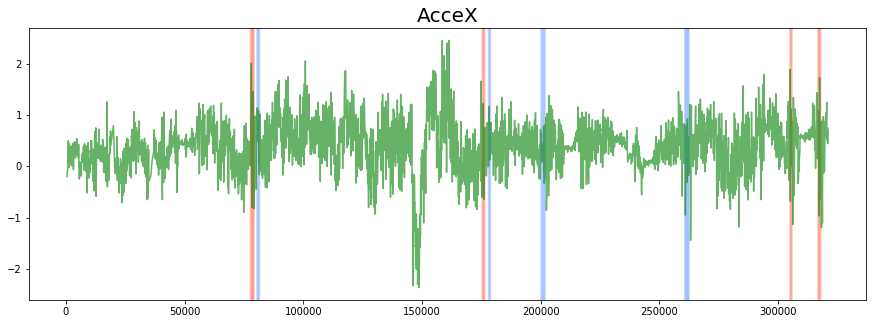

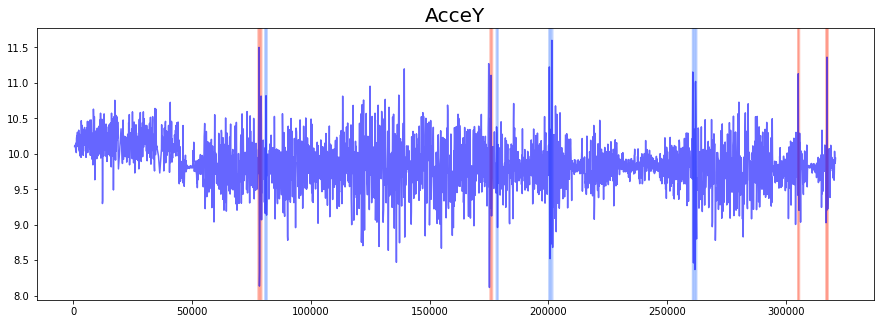

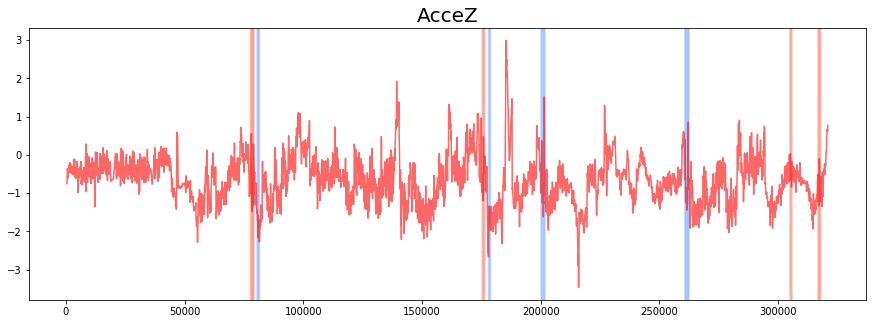

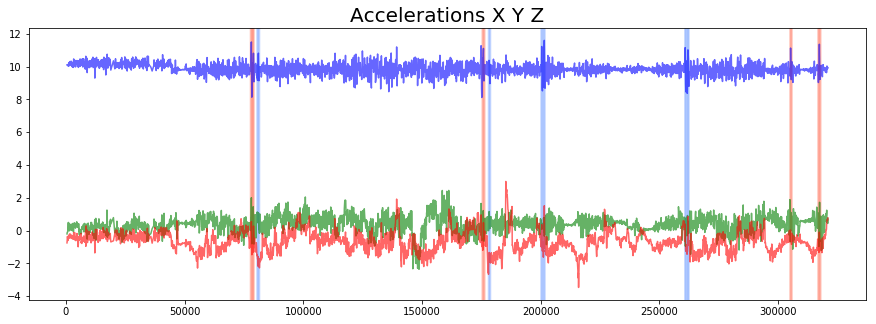

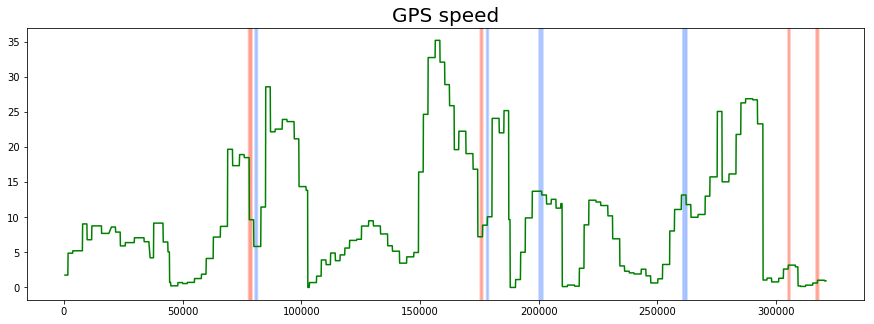

In [18]:
######################_visualize_anomalies_##########################
plt.rcParams["figure.figsize"] = [15,5]

x=train_data.timeCount
y0=train_data.gpsSpeed
y1=train_data.acceX_raw
y2=train_data.acceY_raw
y3=train_data.acceZ_raw


bumps=train_data.loc[train_data['anomaly']==1]
potholes=train_data.loc[train_data['anomaly']==-1]


x_p=potholes.timeCount
x_b=bumps.timeCount

# pothole blue line
# bumps red line
def add_anomaly_lines(plt_):
    for l in x_p:
        plt_.axvline(x=l,linewidth=0.2, color='#FF6347')
    
    for l in x_b:
        plt_.axvline(x=l,linewidth=0.2, color='#6698FF')


add_anomaly_lines(plt)
plt.plot(x,y1,'g',alpha=.6)
plt.title("AcceX",fontsize=20)
plt.show()

add_anomaly_lines(plt)
plt.plot(x,y2,'b',alpha=.6)
plt.title("AcceY",fontsize=20)
plt.show()

add_anomaly_lines(plt)
plt.plot(x,y3,'r',alpha=.6)
plt.title("AcceZ",fontsize=20)
plt.show()

add_anomaly_lines(plt)
plt.plot(x,y1,'g',x,y2,'b',x,y3,'r',alpha=0.6)
plt.title("Accelerations X Y Z",fontsize=20)
plt.show()

add_anomaly_lines(plt)
plt.plot(x,y0,'g',alpha=1)
plt.title("GPS speed",fontsize=20)
plt.show()

#####################################################################

In [5]:
######################_selecting_affecting_columns_##################

all_cols=train_data.columns 
# ['acceX','acceX_raw','acceY','acceY_raw','acceZ','acceZ_raw',
# 'anomaly','count','dataType','gpsSpeed','id','imei','journeyID','lat','lon','obdRpm','obdSpeed','time','timeCount',
# 'acceX_n1','acceX_n2','acceX_n3','acceX_n4','acceX_n5','acceX_p1','acceX_p2','acceX_p3','acceX_p4','acceX_p5',
# 'acceY_n1','acceY_n2','acceY_n3','acceY_n4','acceY_n5','acceY_p1','acceY_p2','acceY_p3','acceY_p4','acceY_p5',
# 'acceZ_n1','acceZ_n2','acceZ_n3','acceZ_n4','acceZ_n5','acceZ_p1','acceZ_p2','acceZ_p3','acceZ_p4','acceZ_p5',
# 'rms_X','rms_Y','rms_Z']


# predicting_cols=all_cols.drop(['trip_duration','id','imei']) 

predicting_cols=['acceX_raw', 'acceY_raw','acceZ_raw']
#####################################################################


In [6]:
# # plot heatmap only down side
# corr = train_data[predicting_cols+['anomaly']].corr()
# f,ax = plt.subplots(figsize=(15, 15))
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
# with sns.axes_style("white"):
#     ax_ = sns.heatmap(corr, mask=mask,linewidths=3,annot=True,ax=ax)

In [7]:
######################_checking_missing_values_######################
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# draw_missing_data_table(X)

#######################################################################

In [8]:
# imputering if need

In [9]:
# ######################_spliting_data_X_y_############################
# deviding training data for checking correctness
train_X,test_X,train_y,test_y=train_test_split(train_data,train_data.anomaly,random_state=42,test_size=0.3,shuffle=False)


######################_X_y_predictingX_##############################
train_X=train_X[predicting_cols]
test_X_all=test_X.copy()
test_X=test_X[predicting_cols]
#####################################################################


#####################################################################

In [10]:
######################_model_selection_##############################
def get_mae_model(model_,X, y):
	# model=DecisionTreeRegressor()
    model=model_
    mae_val= -1 * cross_val_score(model, X, y, scoring = 'neg_mean_absolute_error').mean()
    print("MAE with ",type(model).__name__," \t:",mae_val)
    return mae_val


# get_mae_model(DecisionTreeRegressor(),train_X,train_y)
# get_mae_model(RandomForestRegressor(),train_X,train_y)
# get_mae_model(XGBRegressor(),train_X,train_y)
# get_mae_model(GradientBoostingRegressor(),train_X,train_y)
# get_mae_model(RandomForestClassifier(),train_X,train_y)

#####################################################################

In [11]:
######################_trainging_the_model_##########################
# find the number of nodes for least MAE and create the model according to it
# model=DecisionTreeRegressor(max_leaf_nodes=75,random_state=0)  #model with specifying max leaf nodes
# model.fit(train_X, train_y)


# model=RandomForestClassifier()  #model with specifying max leaf nodes
# model.fit(train_X, train_y)

# model=XGBRegressor()
# scpecify n_jobs for XGBRegressor if dataset is too large. assign num of cores in machine to n_jobs 
# find using early_stopping_rounds and assign it to n_estimators, start with a big number

model=XGBRegressor(n_estimators=2000,learning_rate=0.05)
model.fit(train_X,train_y,early_stopping_rounds=20, eval_set=[(test_X, test_y)], verbose=False)

#####################################################################

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
######################_evaluating_the_model_#########################
predicted_values_for_traininig_set_raw=model.predict(test_X)
# predicted_values_for_traininig_set=pipeline.predict(imputed_X_test)

def round_result(x):
    return int(round(x))

predicted_values_for_traininig_set=[round_result(x) for x in predicted_values_for_traininig_set_raw]

# print correct and predicted values
# print("actual",'predicted\n')
# for idx,val in enumerate(test_y):
# 	print (val,predicted_values_for_traininig_set[idx])

# print mean absolute error
print("\nMAE:\t",mean_absolute_error(test_y,predicted_values_for_traininig_set))
#####################################################################


MAE:	 0.04421052631578947


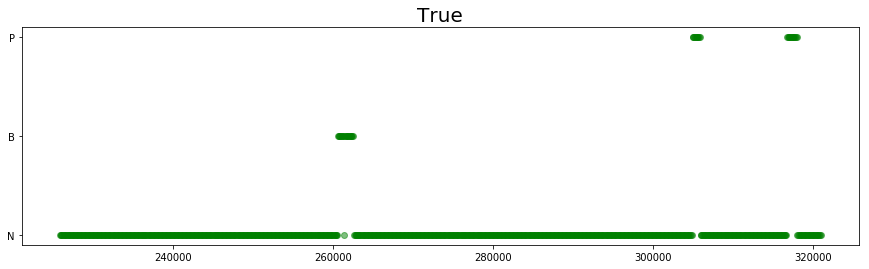

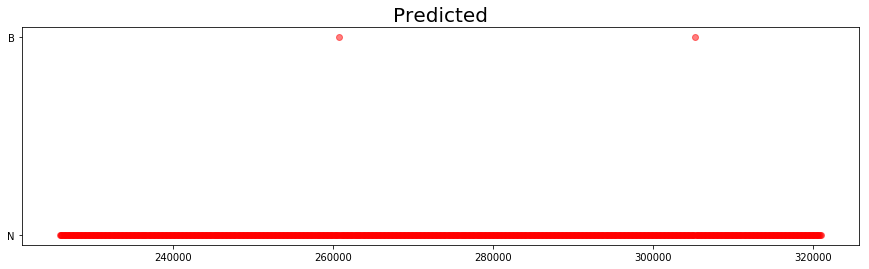

In [13]:
######################_visualizing_test_data_prediction_#############
# test_X, test_y
x=test_X_all.timeCount
y=test_y
y_=y.copy()
y_= [decode_anomaly(x) for x in y_]

y2=predicted_values_for_traininig_set
y2_=y2.copy()
y2_=[decode_anomaly(x) for x in y2_]

plt.rcParams["figure.figsize"] = [15,4]
# plt.plot(x,y,'ro',x,y2,'bo',alpha=0.1)
# plt.show()

plt.plot(x,y_,'go',alpha=0.5)
plt.title("True",fontsize=20)
plt.show()

plt.plot(x,y2_,'ro',alpha=0.5)
plt.title("Predicted",fontsize=20)
plt.show()
#####################################################################

In [14]:
######################_prediction_for_required_data_#################
# predicting data
# j7ThalallaRandom2.json
# j7uduwila1.json
# j7uduwila2.json

predicting_data_file_path='predicting_data/j7ThalallaRandom2.json'
predicting_data = pd.read_json(predicting_data_file_path)
print("predicting data size: ",len(predicting_data))


predicting_data['timeCount']=predicting_data['time'].apply(lambda x: x)
predicting_data['anomaly'] = predicting_data['anomaly'].apply(lambda x: encode_anomaly(x))

predicting_X=predicting_data[predicting_cols]


           ######################
    
predicted_result_raw=model.predict(predicting_X)

predicted_result=[round_result(x) for x in predicted_result_raw]

#####################################################################

predicting data size:  2600


In [15]:
# predicting_data.dtypes

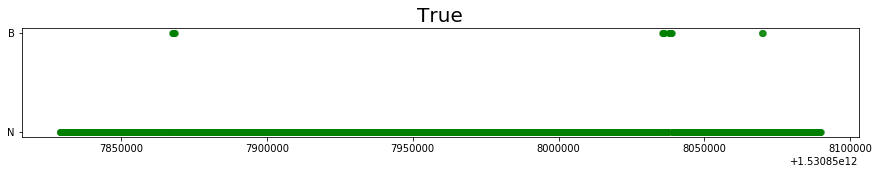

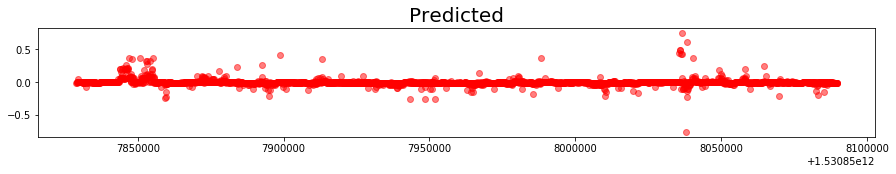

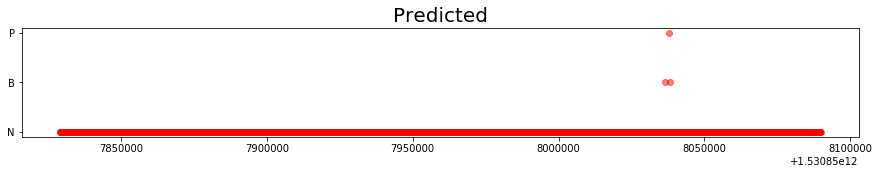

In [16]:
# test_X, test_y
x=predicting_data.timeCount
y=predicting_data.anomaly
y_=y.copy()
y_= [decode_anomaly(x) for x in y_]

y2=predicted_result_raw
y2_=y2.copy()
y2_=[decode_anomaly(x) for x in y2_]

y3=predicted_result
y3_=y3.copy()
y3_=[decode_anomaly(x) for x in y3_]

plt.rcParams["figure.figsize"] = [15,2]
# plt.plot(x,y,'ro',x,y2,'bo',alpha=0.1)
# plt.show()

plt.plot(x,y_,'go',alpha=0.5)
plt.title("True",fontsize=20)
plt.show()

plt.plot(x,y2_,'ro',alpha=0.5)
plt.title("Predicted unedited",fontsize=20)
plt.show()

plt.plot(x,y3_,'ro',alpha=0.5)
plt.title("Predicted rounded",fontsize=20)
plt.show()

In [17]:
######################_save_the_predicted_data_######################

# creating a csv
# submission = pd.DataFrame({'Id': predicting_data.Id, 'SalePrice': predicted_result})
# submission.to_csv('submission.csv', index=False)

# creating txt file
# np.savetxt('output.txt',predicted_result,fmt='%.2f')

#####################################################################
#                                                                   #
#                                END                                #
#                                                                   #
#####################################################################